<a href="https://colab.research.google.com/github/subharthibanerjee/1806/blob/master/sionna_requirement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import tensorflow as tf

# Import Sionna
try:
    import sionna
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna

In [3]:
gpus = tf.config.list_physical_devices('GPU')
print('Number of GPUs available :', len(gpus))
if gpus:
    gpu_num = 0 # Index of the GPU to be used
    try:
        #tf.config.set_visible_devices([], 'GPU')
        tf.config.set_visible_devices(gpus[gpu_num], 'GPU')
        print('Only GPU number', gpu_num, 'used.')
        tf.config.experimental.set_memory_growth(gpus[gpu_num], True)
    except RuntimeError as e:
        print(e)

Number of GPUs available : 1
Only GPU number 0 used.


In [4]:
# probably GPU available over there working in the colab environment

# IPython "magic function" for inline plots
%matplotlib inline
import matplotlib.pyplot as plt

In [5]:
!nvidia-smi

Mon Oct 31 04:14:56 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
# above -> GPU information
# later just init the channel
channel = sionna.channel.AWGN() # init AWGN channel layer

In [7]:
# define transmission paramters

# define a (complex-valued) tensor to be transmitted
x = tf.constant([[0., 1.5, 1., 0.],[-1., 0., -2, 3 ]], dtype=tf.complex64)

# let's have look at the shape
print("Shape of x: ", x.shape)
print("Values of x: ", x)


Shape of x:  (2, 4)
Values of x:  tf.Tensor(
[[ 0. +0.j  1.5+0.j  1. +0.j  0. +0.j]
 [-1. +0.j  0. +0.j -2. +0.j  3. +0.j]], shape=(2, 4), dtype=complex64)


In [8]:
ebno_db = 5

# calculate noise variance from given EbNo
no = sionna.utils.ebnodb2no(ebno_db = ebno_db,
                            num_bits_per_symbol=2, # QPSK
                            coderate=1) 
y = channel([x, no])

print("Noisy symbols are: ", y)

Noisy symbols are:  tf.Tensor(
[[ 0.0232138 -0.02759837j  1.3280628 +0.41721243j  1.3527036 -0.4068156j
   0.33901447-0.39161706j]
 [-1.2132162 -0.16667987j -0.44880214+0.21655983j -1.917533  -0.4223001j
   3.3523693 +0.16768077j]], shape=(2, 4), dtype=complex64)


In [9]:
batch_size = 100 # outer level of parallelism
num_codewords = 64 # codewords per batch sample
info_bit_length = 500 # info bits per codeword

source = sionna.utils.BinarySource() # yields random bits

u = source([batch_size, num_codewords, info_bit_length]) # call the source layer
print("Shape of u: ", u.shape)

# initialize an CRC encoder with the standard compliant "CRC24A" polynomial
encoder_crc = sionna.fec.crc.CRCEncoder("CRC24A")
decoder_crc = sionna.fec.crc.CRCDecoder(encoder_crc) # connect to encoder

# add the CRC to the information bits u
c = encoder_crc(u) # returns a list [c, crc_valid]
print("Shape of c: ", c.shape)
print("Processed bits: ", np.size(c.numpy()))

# we can also verify the results
# returns list of [info bits without CRC bits, indicator if CRC holds]
u_hat, crc_valid = decoder_crc(c) 
print("Shape of u_hat: ", u_hat.shape)
print("Shape of crc_valid: ", crc_valid.shape)

print("Valid CRC check of first codeword: ", crc_valid.numpy()[0,0,0])


Shape of u:  (100, 64, 500)
Shape of c:  (100, 64, 524)
Processed bits:  3353600
Shape of u_hat:  (100, 64, 500)
Shape of crc_valid:  (100, 64, 1)
Valid CRC check of first codeword:  True


In [10]:
num_users = 5

u = source([batch_size, num_users, num_codewords, info_bit_length]) 
print("New shape of u: ", u.shape)

# We can re-use the same encoder as before
c = encoder_crc(u)
print("New shape of c: ", c.shape)
print("Processed bits: ", np.size(c.numpy()))

New shape of u:  (100, 5, 64, 500)
New shape of c:  (100, 5, 64, 524)
Processed bits:  16768000


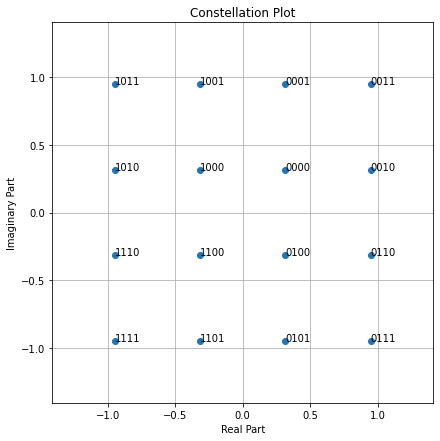

In [11]:
constellation = sionna.mapping.Constellation("qam", num_bits_per_symbol=4)
constellation.show();

In [12]:
# system parameters
n_ldpc = 500 # LDPC codeword length 
k_ldpc = 250 # number of info bits per LDPC codeword
coderate = k_ldpc / n_ldpc
num_bits_per_symbol = 4 # number of bits mapped to one symbol (cf. QAM)

In [13]:
demapping_method = "app" # try "max-log"
ldpc_cn_type = "boxplus" # try also "minsum"

In [14]:
binary_source = sionna.utils.BinarySource()
encoder = sionna.fec.ldpc.encoding.LDPC5GEncoder(k_ldpc, n_ldpc)
constellation = sionna.mapping.Constellation("qam", num_bits_per_symbol)
mapper = sionna.mapping.Mapper(constellation=constellation)
channel = sionna.channel.AWGN()
demapper = sionna.mapping.Demapper(demapping_method,
                                   constellation=constellation)
decoder = sionna.fec.ldpc.decoding.LDPC5GDecoder(encoder,
                                                 hard_out=True, cn_type=ldpc_cn_type,
                                                 num_iter=20)

In [15]:
# simulation parameters
batch_size = 1000
ebno_db = 4

# Generate a batch of random bit vectors
b = binary_source([batch_size, k_ldpc])

# Encode the bits using 5G LDPC code
print("Shape before encoding: ", b.shape)
c = encoder(b)
print("Shape after encoding: ", c.shape)

# Map bits to constellation symbols
x = mapper(c)
print("Shape after mapping: ", x.shape)

# Transmit over an AWGN channel at SNR 'ebno_db'
no = sionna.utils.ebnodb2no(ebno_db, num_bits_per_symbol, coderate)
y = channel([x, no])
print("Shape after channel: ", y.shape)

# Demap to LLRs
llr = demapper([y, no])
print("Shape after demapping: ", llr.shape)

# LDPC decoding using 20 BP iterations
b_hat = decoder(llr)
print("Shape after decoding: ", b_hat.shape)

# calculate BERs
c_hat = tf.cast(tf.less(0.0, llr), tf.float32) # hard-decided bits before dec.
ber_uncoded = sionna.utils.metrics.compute_ber(c, c_hat)

ber_coded = sionna.utils.metrics.compute_ber(b, b_hat)

print("BER uncoded = {:.3f} at EbNo = {:.1f} dB".format(ber_uncoded, ebno_db))
print("BER after decoding = {:.3f} at EbNo = {:.1f} dB".format(ber_coded, ebno_db))
print("In total {} bits were simulated".format(np.size(b.numpy())))


Shape before encoding:  (1000, 250)
Shape after encoding:  (1000, 500)
Shape after mapping:  (1000, 125)
Shape after channel:  (1000, 125)
Shape after demapping:  (1000, 500)
Shape after decoding:  (1000, 250)
BER uncoded = 0.119 at EbNo = 4.0 dB
BER after decoding = 0.011 at EbNo = 4.0 dB
In total 250000 bits were simulated


In [17]:
class e2e_model(tf.keras.Model): # inherits from keras.model
    """Example model for end-to-end link-level simulations.
    
    Parameters
    ----------
    params: dict
        A dictionary defining the system parameters.
    
    Input
    -----
    batch_size: int or tf.int
        The batch_sizeused for the simulation.
        
    ebno_db: float or tf.float
        A float defining the simulation SNR.

    Output
    ------
    (b, b_hat): 
        Tuple:
    
    b: tf.float32
        A tensor of shape `[batch_size, k]` containing the transmitted
        information bits.

    b_hat: tf.float32
        A tensor of shape `[batch_size, k]` containing the receiver's
        estimate of the transmitted information bits.
    """
    def __init__(self,
                params):
        super().__init__()       

        
        # Define an OFDM Resource Grid Object
        self.rg = sionna.ofdm.ResourceGrid(
                            num_ofdm_symbols=params["num_ofdm_symbols"],
                            fft_size=params["fft_size"],
                            subcarrier_spacing=params["subcarrier_spacing"],
                            num_tx=1,
                            num_streams_per_tx=1,
                            cyclic_prefix_length=params["cyclic_prefix_length"],
                            pilot_pattern="kronecker",
                            pilot_ofdm_symbol_indices=params["pilot_ofdm_symbol_indices"])
              
        # Create a Stream Management object        
        self.sm = sionna.mimo.StreamManagement(rx_tx_association=np.array([[1]]),
                                               num_streams_per_tx=1)
        
        self.coderate = params["coderate"]
        self.num_bits_per_symbol = params["num_bits_per_symbol"]
        self.n = int(self.rg.num_data_symbols*self.num_bits_per_symbol) 
        self.k = int(self.n*coderate)         

        # Init layers
        self.binary_source = sionna.utils.BinarySource()
        self.encoder = sionna.fec.ldpc.encoding.LDPC5GEncoder(self.k, self.n)
        self.interleaver = sionna.fec.interleaving.RowColumnInterleaver(
                                        row_depth=self.num_bits_per_symbol)
        self.deinterleaver = sionna.fec.interleaving.Deinterleaver(self.interleaver)
        self.mapper = sionna.mapping.Mapper("qam", self.num_bits_per_symbol)
        self.rg_mapper = sionna.ofdm.ResourceGridMapper(self.rg)
        self.tdl = sionna.channel.tr38901.TDL(model="A",
                           delay_spread=params["delay_spread"],
                           carrier_frequency=params["carrier_frequency"],
                           min_speed=params["min_speed"],
                           max_speed=params["max_speed"])
        
        self.channel = sionna.channel.OFDMChannel(self.tdl, self.rg, add_awgn=True, normalize_channel=True)
        self.ls_est = sionna.ofdm.LSChannelEstimator(self.rg, interpolation_type="nn")
        self.lmmse_equ = sionna.ofdm.LMMSEEqualizer(self.rg, self.sm)
        self.demapper = sionna.mapping.Demapper(params["demapping_method"],
                                                "qam", self.num_bits_per_symbol)
        self.decoder = sionna.fec.ldpc.decoding.LDPC5GDecoder(self.encoder,
                                                    hard_out=True,
                                                    cn_type=params["cn_type"],
                                                    num_iter=params["bp_iter"])

        print("Number of pilots: {}".format(self.rg.num_pilot_symbols))        
        print("Number of data symbols: {}".format(self.rg.num_data_symbols))
        print("Number of resource elements: {}".format(
                                    self.rg.num_resource_elements))

        print("Pilot overhead: {:.2f}%".format(
                                    self.rg.num_pilot_symbols /
                                    self.rg.num_resource_elements*100))

        print("Cyclic prefix overhead: {:.2f}%".format(
                                    params["cyclic_prefix_length"] /
                                    (params["cyclic_prefix_length"]
                                    +params["fft_size"])*100))

        print("Each frame contains {} information bits".format(self.k))
   
    def call(self, batch_size, ebno_db):
        
        # Generate a batch of random bit vectors
        # We need two dummy dimension representing the number of
        # transmitters and streams per transmitter, respectively.
        b = self.binary_source([batch_size, 1, 1, self.k])

        # Encode the bits using the all-zero dummy encoder
        c = self.encoder(b)

        # Interleave the bits before mapping (BICM)
        c_int = self.interleaver(c)
        
        # Map bits to constellation symbols
        s = self.mapper(c_int)

        # Map symbols onto OFDM ressource grid
        x_rg = self.rg_mapper(s)

        # Transmit over noisy multi-path channel 
        no = sionna.utils.ebnodb2no(ebno_db, self.num_bits_per_symbol, self.coderate, self.rg)
        y = self.channel([x_rg, no]) 
        
        # LS Channel estimation with nearest pilot interpolation
        h_hat, err_var = self.ls_est ([y, no])

        # LMMSE Equalization
        x_hat, no_eff = self.lmmse_equ([y, h_hat, err_var, no])

        # Demap to LLRs
        llr = self.demapper([x_hat, no_eff])

        # Deinterleave before decoding
        llr_int = self.deinterleaver(llr)

        # Decode
        b_hat = self.decoder(llr_int) 
        
        # number of simulated bits
        nb_bits = batch_size*self.k
        
        # transmitted bits and the receiver's estimate after decoding
        return b, b_hat

In [18]:
sys_params = {
    # Channel
    "carrier_frequency" : 3.5e9,
    "delay_spread" : 100e-9,
    "min_speed" : 3,
    "max_speed" : 3,
    "tdl_model" : "A",

    # OFDM
    "fft_size" : 256,
    "subcarrier_spacing" : 30e3,
    "num_ofdm_symbols" : 14,
    "cyclic_prefix_length" : 16,
    "pilot_ofdm_symbol_indices" : [2, 11],

    # Code & Modulation
    "coderate" : 0.5,
    "num_bits_per_symbol" : 4,
    "demapping_method" : "app",
    "cn_type" : "boxplus",
    "bp_iter" : 20
}


In [19]:
model = e2e_model(sys_params)

Number of pilots: 512
Number of data symbols: 3072
Number of resource elements: 3584
Pilot overhead: 14.29%
Cyclic prefix overhead: 5.88%
Each frame contains 6144 information bits


In [20]:
#simulation parameters
ebno_db = 10
batch_size = 200

# and call the model
b, b_hat = model(batch_size, ebno_db)

ber = sionna.utils.metrics.compute_ber(b, b_hat)
nb_bits = np.size(b.numpy())

print("BER: {:.4} at Eb/No of {} dB and {} simulated bits".format(ber.numpy(), ebno_db, nb_bits))


BER: 0.004111 at Eb/No of 10 dB and 1228800 simulated bits


In [21]:
import time # this block requires the timeit library

batch_size = 200
ebno_db = 5 # evalaute SNR point
repetitions = 4 # throughput is averaged over multiple runs

def get_throughput(batch_size, ebno_db, model, repetitions=1):
    """ Simulate throughput in bit/s per ebno_db point.
    
    The results are average over `repetition` trials.
    
    Input
    -----
    batch_size: int or tf.int32
        Batch-size for evaluation.

    ebno_db: float or tf.float32
        A tensor containing the SNR points be evaluated    
    
    model:
        Function or model that yields the transmitted bits `u` and the
        receiver's estimate `u_hat` for a given ``batch_size`` and
        ``ebno_db``.
        
    repetitions: int
        An integer defining how many trails of the throughput 
        simulation are averaged.
    
    """


    # call model once to be sure it is compile properly 
    # otherwise time to build graph is measured as well.
    u, u_hat = model(tf.constant(batch_size, tf.int32),    
                     tf.constant(ebno_db, tf.float32))

    t_start = time.perf_counter()
    # average over multiple runs
    for _ in range(repetitions):
        u, u_hat = model(tf.constant(batch_size, tf.int32),
                            tf.constant(ebno_db, tf. float32))
    t_stop = time.perf_counter()

    # throughput in bit/s
    throughput = np.size(u.numpy())*repetitions / (t_stop - t_start)

    return throughput

# eager mode - just call the model
def run_eager(batch_size, ebno_db):
    return model(batch_size, ebno_db)
    
time_eager = get_throughput(batch_size, ebno_db, run_eager, repetitions=4)

# the decorator "@tf.function" enables the graph mode
@tf.function
def run_graph(batch_size, ebno_db):
    return model(batch_size, ebno_db)

time_graph = get_throughput(batch_size, ebno_db, run_graph, repetitions=4)

# the decorator "@tf.function(jit_compile=True)" enables the graph mode with XLA
# we need to activate the sionna.config.xla_compat feature for this to work
sionna.config.xla_compat=True
@tf.function(jit_compile=True)
def run_graph_xla(batch_size, ebno_db):
    return model(batch_size, ebno_db)

time_graph_xla = get_throughput(batch_size, ebno_db, run_graph_xla, repetitions=4)
# we deactivate the sionna.config.xla_compat so that the cell can be run mutiple times
sionna.config.xla_compat=False

print(f"Throughput in eager execution: {time_eager/1e6:.2f} Mb/s")
print(f"Throughput in graph execution: {time_graph/1e6:.2f} Mb/s")
print(f"Throughput in graph execution with XLA: {time_graph_xla/1e6:.2f} Mb/s")


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


Throughput in eager execution: 0.79 Mb/s
Throughput in graph execution: 2.08 Mb/s
Throughput in graph execution with XLA: 15.39 Mb/s


In [22]:
ebno_dbs = np.arange(0, 15, 1.)
batch_size = 200 # reduce in case you receive an out-of-memory (OOM) error

max_mc_iter = 1000 # max number of Monte-Carlo iterations before going to next SNR point
num_target_block_errors = 500 # continue with next SNR point after target number of block errors

# we use the built-in ber simulator function from Sionna which uses and early stop after reaching num_target_errors   
sionna.config.xla_compat=True
ber_mc,_ = sionna.utils.sim_ber(run_graph_xla, # you can also evaluate the model directly
                                ebno_dbs,
                                batch_size=batch_size, 
                                num_target_block_errors=num_target_block_errors,
                                max_mc_iter=max_mc_iter,
                                verbose=True) # print status and summary
sionna.config.xla_compat=False

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 3.4282e-01 | 1.0000e+00 |     1263780 |     3686400 |          600 |         600 |         0.4 |reached target block errors
      1.0 | 3.2086e-01 | 1.0000e+00 |     1182824 |     3686400 |          600 |         600 |         0.3 |reached target block errors
      2.0 | 2.9780e-01 | 1.0000e+00 |     1097809 |     3686400 |          600 |         600 |         0.3 |reached target block errors
      3.0 | 2.7278e-01 | 1.0000e+00 |     1005578 |     3686400 |          600 |         600 |         0.4 |reached target block errors
      4.0 | 2.4753e-01 | 1.0000e+00 |      912491 |     3686400 |          600 |         600 |         0.4 |reached target block errors
      5.0 | 2.1920e-01 | 1.0000e+00 |      808067 |     3686400 |

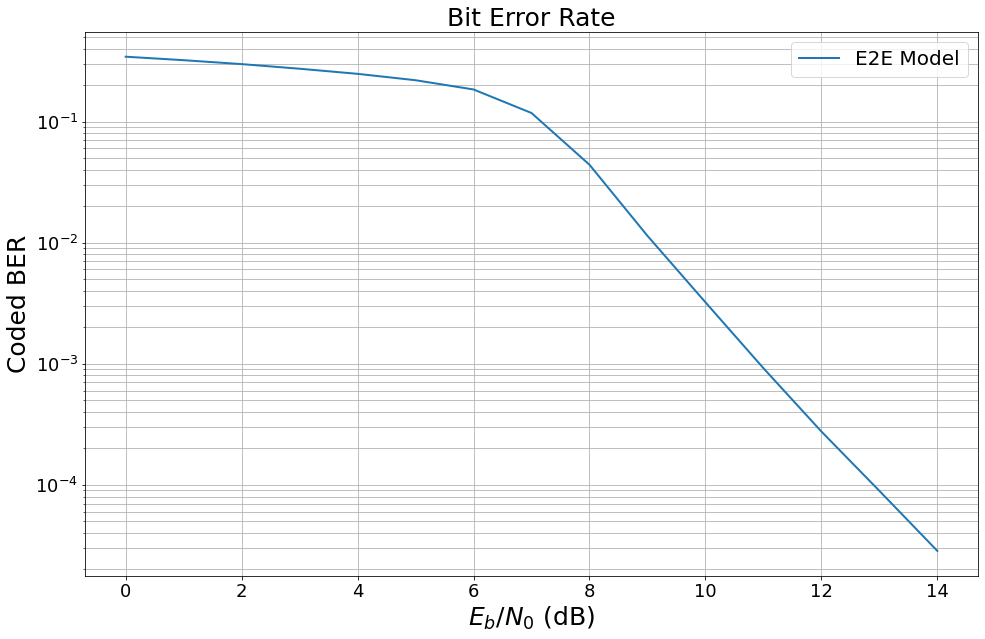

In [23]:
sionna.utils.plotting.plot_ber(ebno_dbs,
                               ber_mc,
                               legend="E2E Model",
                               ylabel="Coded BER");